In [10]:
# ============================================
# Q4: BETTING MARKET COMPARISON
# ============================================

# Imports
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, roc_auc_score
from scipy.stats import ttest_1samp, binomtest
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

print("✓ Libraries loaded")

# Load data
test_df = pd.read_csv('test_data_with_predictions.csv')
test_df['date'] = pd.to_datetime(test_df['date'])

print(f"✓ Data loaded: {len(test_df):,} rows, {test_df['race_id'].nunique():,} races")

print("="*60)
print("Q4: MODEL PERFORMANCE vs BETFAIR STARTING PRICE")
print("="*60)

# --------------------------------------------
# Step 0: Load Test Data with Predictions
# --------------------------------------------

print("\n### STEP 0: LOAD DATA ###\n")


print(f"Test data loaded:")
print(f"  Rows: {len(test_df):,}")
print(f"  Races: {test_df['race_id'].nunique():,}")
print(f"  Date range: {test_df['date'].min().date()} to {test_df['date'].max().date()}")

# Check required columns exist
required_cols = ['model_win_probability_calibrated', 'obs__bsp', 'obs__is_winner']
for col in required_cols:
    if col not in test_df.columns:
        print(f"❌ Missing column: {col}")
    else:
        print(f"✓ {col} present")

# --------------------------------------------
# Step 1: Convert Betfair Odds to Probabilities
# --------------------------------------------

print("\n### STEP 1: CONVERT BETFAIR ODDS TO PROBABILITIES ###\n")

# Betfair odds are in decimal format
# Implied probability = 1 / odds
test_df['market_probability'] = 1 / test_df['obs__bsp']

# Market probabilities typically sum to > 1 due to overround (bookmaker margin)
# Calculate overround per race
test_df['market_overround'] = test_df.groupby('race_id')['market_probability'].transform('sum')

# Normalize market probabilities to sum to 1 (remove overround)
test_df['market_probability_normalized'] = test_df['market_probability'] / test_df['market_overround']

print("Betfair odds converted to probabilities:")
print(f"  Mean raw market probability: {test_df['market_probability'].mean():.3f}")
print(f"  Mean overround per race: {test_df['market_overround'].mean():.3f} (avg {(test_df['market_overround'].mean()-1)*100:.1f}% margin)")
print(f"  Mean normalized probability: {test_df['market_probability_normalized'].mean():.3f}")

# Verify normalized probabilities sum to 1
race_sums = test_df.groupby('race_id')['market_probability_normalized'].sum()
print(f"\n✓ Normalized probabilities sum to 1.0: {np.allclose(race_sums, 1.0)}")

# --------------------------------------------
# Step 2: Compare Model vs Market Accuracy
# --------------------------------------------

print("\n### STEP 2: ACCURACY COMPARISON ###\n")

# Calculate log loss (lower is better)
from sklearn.metrics import log_loss

model_logloss = log_loss(test_df['obs__is_winner'], test_df['model_win_probability_calibrated'])
market_logloss = log_loss(test_df['obs__is_winner'], test_df['market_probability_normalized'])

print("LOG LOSS COMPARISON (lower = better):")
print(f"  Model Log Loss:  {model_logloss:.4f}")
print(f"  Market Log Loss: {market_logloss:.4f}")
print(f"  Difference:      {model_logloss - market_logloss:.4f}")

if model_logloss < market_logloss:
    print(f"  ✓ Model BEATS market by {market_logloss - model_logloss:.4f}")
else:
    print(f"  ✗ Market BEATS model by {model_logloss - market_logloss:.4f}")

# ROC-AUC comparison
from sklearn.metrics import roc_auc_score

model_auc = roc_auc_score(test_df['obs__is_winner'], test_df['model_win_probability_calibrated'])
market_auc = roc_auc_score(test_df['obs__is_winner'], test_df['market_probability_normalized'])

print(f"\nROC-AUC COMPARISON (higher = better):")
print(f"  Model ROC-AUC:   {model_auc:.4f}")
print(f"  Market ROC-AUC:  {market_auc:.4f}")
print(f"  Difference:      {model_auc - market_auc:.4f}")

if model_auc > market_auc:
    print(f"  ✓ Model BEATS market by {model_auc - market_auc:.4f}")
else:
    print(f"  ✗ Market BEATS model by {model_auc - market_auc:.4f}")

# --------------------------------------------
# Step 3: Identify Value Bets
# --------------------------------------------

print("\n### STEP 3: IDENTIFY VALUE BETS ###\n")

# Value = when model probability > market probability
test_df['probability_edge'] = test_df['model_win_probability_calibrated'] - test_df['market_probability_normalized']

# Classify bets
test_df['has_value'] = (test_df['probability_edge'] > 0).astype(int)
test_df['strong_value'] = (test_df['probability_edge'] > 0.05).astype(int)  # 5%+ edge

print(f"Value bet analysis:")
print(f"  Total runners: {len(test_df):,}")
print(f"  Runners with positive edge: {test_df['has_value'].sum():,} ({test_df['has_value'].mean():.1%})")
print(f"  Runners with 5%+ edge: {test_df['strong_value'].sum():,} ({test_df['strong_value'].mean():.1%})")

# Check win rates for value bets
print(f"\nWin rates:")
print(f"  All runners: {test_df['obs__is_winner'].mean():.2%}")
print(f"  Positive edge runners: {test_df[test_df['has_value']==1]['obs__is_winner'].mean():.2%}")
print(f"  Strong edge (5%+) runners: {test_df[test_df['strong_value']==1]['obs__is_winner'].mean():.2%}")

# --------------------------------------------
# Step 4: Profitable Betting Strategies
# --------------------------------------------

print("\n### STEP 4: BETTING STRATEGIES (Zero Commission) ###\n")

# Strategy 1: Bet on all positive edge runners
strategy1_df = test_df[test_df['has_value'] == 1].copy()
strategy1_df['stake'] = 1  # Bet £1 on each
strategy1_df['payout'] = strategy1_df['obs__is_winner'] * strategy1_df['obs__bsp'] * strategy1_df['stake']
strategy1_df['profit'] = strategy1_df['payout'] - strategy1_df['stake']

strategy1_total_staked = strategy1_df['stake'].sum()
strategy1_total_returned = strategy1_df['payout'].sum()
strategy1_profit = strategy1_df['profit'].sum()
strategy1_roi = (strategy1_profit / strategy1_total_staked) * 100

print("STRATEGY 1: Bet on all positive edge runners")
print(f"  Bets placed: {len(strategy1_df):,}")
print(f"  Total staked: £{strategy1_total_staked:,.0f}")
print(f"  Total returned: £{strategy1_total_returned:,.2f}")
print(f"  Profit/Loss: £{strategy1_profit:,.2f}")
print(f"  ROI: {strategy1_roi:.2f}%")

if strategy1_roi > 0:
    print(f"  ✓ PROFITABLE")
else:
    print(f"  ✗ Not profitable")

# Strategy 2: Bet only on strong edge (5%+)
strategy2_df = test_df[test_df['strong_value'] == 1].copy()
strategy2_df['stake'] = 1
strategy2_df['payout'] = strategy2_df['obs__is_winner'] * strategy2_df['obs__bsp'] * strategy2_df['stake']
strategy2_df['profit'] = strategy2_df['payout'] - strategy2_df['stake']

strategy2_total_staked = strategy2_df['stake'].sum()
strategy2_total_returned = strategy2_df['payout'].sum()
strategy2_profit = strategy2_df['profit'].sum()
strategy2_roi = (strategy2_profit / strategy2_total_staked) * 100 if strategy2_total_staked > 0 else 0

print("\nSTRATEGY 2: Bet only on strong edge (5%+ advantage)")
print(f"  Bets placed: {len(strategy2_df):,}")
print(f"  Total staked: £{strategy2_total_staked:,.0f}")
print(f"  Total returned: £{strategy2_total_returned:,.2f}")
print(f"  Profit/Loss: £{strategy2_profit:,.2f}")
print(f"  ROI: {strategy2_roi:.2f}%")

if strategy2_roi > 0:
    print(f"  ✓ PROFITABLE")
else:
    print(f"  ✗ Not profitable")

# Strategy 3: Kelly Criterion (proportional betting based on edge)
# Kelly fraction = (edge) / (odds - 1)
strategy3_df = test_df[test_df['probability_edge'] > 0].copy()
strategy3_df['kelly_fraction'] = strategy3_df['probability_edge'] / (strategy3_df['obs__bsp'] - 1)
strategy3_df['kelly_fraction'] = strategy3_df['kelly_fraction'].clip(0, 0.1)  # Max 10% of bankroll per bet
strategy3_df['stake'] = strategy3_df['kelly_fraction'] * 100  # Assuming £100 bankroll
strategy3_df['payout'] = strategy3_df['obs__is_winner'] * strategy3_df['obs__bsp'] * strategy3_df['stake']
strategy3_df['profit'] = strategy3_df['payout'] - strategy3_df['stake']

strategy3_total_staked = strategy3_df['stake'].sum()
strategy3_total_returned = strategy3_df['payout'].sum()
strategy3_profit = strategy3_df['profit'].sum()
strategy3_roi = (strategy3_profit / strategy3_total_staked) * 100 if strategy3_total_staked > 0 else 0

print("\nSTRATEGY 3: Kelly Criterion (proportional betting)")
print(f"  Bets placed: {len(strategy3_df):,}")
print(f"  Total staked: £{strategy3_total_staked:,.2f}")
print(f"  Total returned: £{strategy3_total_returned:,.2f}")
print(f"  Profit/Loss: £{strategy3_profit:,.2f}")
print(f"  ROI: {strategy3_roi:.2f}%")

if strategy3_roi > 0:
    print(f"  ✓ PROFITABLE")
else:
    print(f"  ✗ Not profitable")

# Strategy 4: Top model picks (highest model probability per race)
strategy4_df = test_df.loc[test_df.groupby('race_id')['model_win_probability_calibrated'].idxmax()].copy()
strategy4_df['stake'] = 1
strategy4_df['payout'] = strategy4_df['obs__is_winner'] * strategy4_df['obs__bsp'] * strategy4_df['stake']
strategy4_df['profit'] = strategy4_df['payout'] - strategy4_df['stake']

strategy4_total_staked = strategy4_df['stake'].sum()
strategy4_total_returned = strategy4_df['payout'].sum()
strategy4_profit = strategy4_df['profit'].sum()
strategy4_roi = (strategy4_profit / strategy4_total_staked) * 100

print("\nSTRATEGY 4: Bet on model's top pick in each race")
print(f"  Bets placed: {len(strategy4_df):,} (one per race)")
print(f"  Total staked: £{strategy4_total_staked:,.0f}")
print(f"  Total returned: £{strategy4_total_returned:,.2f}")
print(f"  Profit/Loss: £{strategy4_profit:,.2f}")
print(f"  ROI: {strategy4_roi:.2f}%")
print(f"  Win rate: {strategy4_df['obs__is_winner'].mean():.2%}")

if strategy4_roi > 0:
    print(f"  ✓ PROFITABLE")
else:
    print(f"  ✗ Not profitable")

# Summary of strategies
strategy_summary = pd.DataFrame({
    'Strategy': ['All Positive Edge', 'Strong Edge (5%+)', 'Kelly Criterion', 'Top Pick Per Race'],
    'Bets': [len(strategy1_df), len(strategy2_df), len(strategy3_df), len(strategy4_df)],
    'Total Staked': [strategy1_total_staked, strategy2_total_staked, strategy3_total_staked, strategy4_total_staked],
    'Profit/Loss': [strategy1_profit, strategy2_profit, strategy3_profit, strategy4_profit],
    'ROI (%)': [strategy1_roi, strategy2_roi, strategy3_roi, strategy4_roi]
})

print("\n### STRATEGY COMPARISON ###")
display(strategy_summary)

# --------------------------------------------
# Step 5: Statistical Significance Testing
# --------------------------------------------

print("\n### STEP 5: STATISTICAL SIGNIFICANCE ###\n")

# Test 1: Is Strategy 1 ROI significantly different from zero?
if len(strategy1_df) > 0:
    profits = strategy1_df['profit'].values
    mean_profit = profits.mean()
    std_profit = profits.std()
    n = len(profits)
    
    # One-sample t-test: Is mean profit different from 0?
    t_stat, p_value = stats.ttest_1samp(profits, 0)
    
    print("TEST 1: Strategy 1 (All Positive Edge) - Is ROI significantly > 0?")
    print(f"  Mean profit per bet: £{mean_profit:.3f}")
    print(f"  Std deviation: £{std_profit:.3f}")
    print(f"  T-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_value:.4f}")
    
    if p_value < 0.05 and mean_profit > 0:
        print(f"  ✓ STATISTICALLY SIGNIFICANT at 5% level (profitable)")
    elif p_value < 0.05 and mean_profit < 0:
        print(f"  ✓ STATISTICALLY SIGNIFICANT at 5% level (unprofitable)")
    else:
        print(f"  ✗ NOT statistically significant (could be luck)")

# Test 2: Do value bets win more than expected by market?
if test_df['has_value'].sum() > 0:
    value_bets = test_df[test_df['has_value'] == 1]
    expected_wins = value_bets['market_probability_normalized'].sum()
    actual_wins = value_bets['obs__is_winner'].sum()
    
    print(f"\nTEST 2: Do value bets outperform market expectations?")
    print(f"  Bets with positive edge: {len(value_bets):,}")
    print(f"  Expected wins (by market): {expected_wins:.1f}")
    print(f"  Actual wins: {actual_wins}")
    print(f"  Difference: {actual_wins - expected_wins:.1f}")
    
    # Binomial test
    from scipy.stats import binomtest

    p_value_binom = binomtest(int(actual_wins), len(value_bets), 
                         value_bets['market_probability_normalized'].mean(),
                         alternative='greater')

    print(f"  P-value (binomial test): {p_value_binom.pvalue:.4f}")

    # Fix: compare p_value_binom.pvalue (not p_value_binom)
    if p_value_binom.pvalue < 0.05:
        print(f"  ✓ STATISTICALLY SIGNIFICANT - Value bets win more than market predicts")
    else:
        print(f"  ✗ NOT statistically significant - Could be due to chance")

# Test 3: Bootstrap confidence interval for ROI
print(f"\nTEST 3: Bootstrap confidence interval for Strategy 1 ROI")

if len(strategy1_df) > 1000:
    n_bootstrap = 1000
    bootstrap_rois = []
    
    for _ in range(n_bootstrap):
        sample = strategy1_df.sample(n=len(strategy1_df), replace=True)
        sample_roi = (sample['profit'].sum() / sample['stake'].sum()) * 100
        bootstrap_rois.append(sample_roi)
    
    ci_lower = np.percentile(bootstrap_rois, 2.5)
    ci_upper = np.percentile(bootstrap_rois, 97.5)
    
    print(f"  95% Confidence Interval for ROI: [{ci_lower:.2f}%, {ci_upper:.2f}%]")
    
    if ci_lower > 0:
        print(f"  ✓ Lower bound > 0 - Strong evidence of profitability")
    elif ci_upper < 0:
        print(f"  ✗ Upper bound < 0 - Strong evidence of unprofitability")
    else:
        print(f"  ? Confidence interval crosses zero - Uncertain profitability")


✓ Libraries loaded
✓ Data loaded: 155,510 rows, 16,411 races
Q4: MODEL PERFORMANCE vs BETFAIR STARTING PRICE

### STEP 0: LOAD DATA ###

Test data loaded:
  Rows: 155,510
  Races: 16,411
  Date range: 2021-01-13 to 2022-04-30
✓ model_win_probability_calibrated present
✓ obs__bsp present
✓ obs__is_winner present

### STEP 1: CONVERT BETFAIR ODDS TO PROBABILITIES ###

Betfair odds converted to probabilities:
  Mean raw market probability: 0.106
  Mean overround per race: 1.004 (avg 0.4% margin)
  Mean normalized probability: 0.106

✓ Normalized probabilities sum to 1.0: True

### STEP 2: ACCURACY COMPARISON ###

LOG LOSS COMPARISON (lower = better):
  Model Log Loss:  0.2801
  Market Log Loss: 0.2772
  Difference:      0.0029
  ✗ Market BEATS model by 0.0029

ROC-AUC COMPARISON (higher = better):
  Model ROC-AUC:   0.7909
  Market ROC-AUC:  0.7972
  Difference:      -0.0064
  ✗ Market BEATS model by -0.0064

### STEP 3: IDENTIFY VALUE BETS ###

Value bet analysis:
  Total runners: 155,51

,Strategy,Bets,Total Staked,Profit/Loss,ROI (%)
0,All Positive Edge,85702,85702.000000,-6374.579000,-7.438075
1,Strong Edge (5%+),4477,4477.000000,31.030000,0.693098
2,Kelly Criterion,85702,24989.993345,568.554713,2.275130
3,Top Pick Per Race,16411,16411.000000,118.740000,0.723539



### STEP 5: STATISTICAL SIGNIFICANCE ###

TEST 1: Strategy 1 (All Positive Edge) - Is ROI significantly > 0?
  Mean profit per bet: £-0.074
  Std deviation: £6.663
  T-statistic: -3.268
  P-value: 0.0011
  ✓ STATISTICALLY SIGNIFICANT at 5% level (unprofitable)

TEST 2: Do value bets outperform market expectations?
  Bets with positive edge: 85,702
  Expected wins (by market): 7344.0
  Actual wins: 7409
  Difference: 65.0
  P-value (binomial test): 0.2156
  ✗ NOT statistically significant - Could be due to chance

TEST 3: Bootstrap confidence interval for Strategy 1 ROI
  95% Confidence Interval for ROI: [-11.84%, -2.80%]
  ✗ Upper bound < 0 - Strong evidence of unprofitability



### STEP 6: VISUALIZATIONS ###



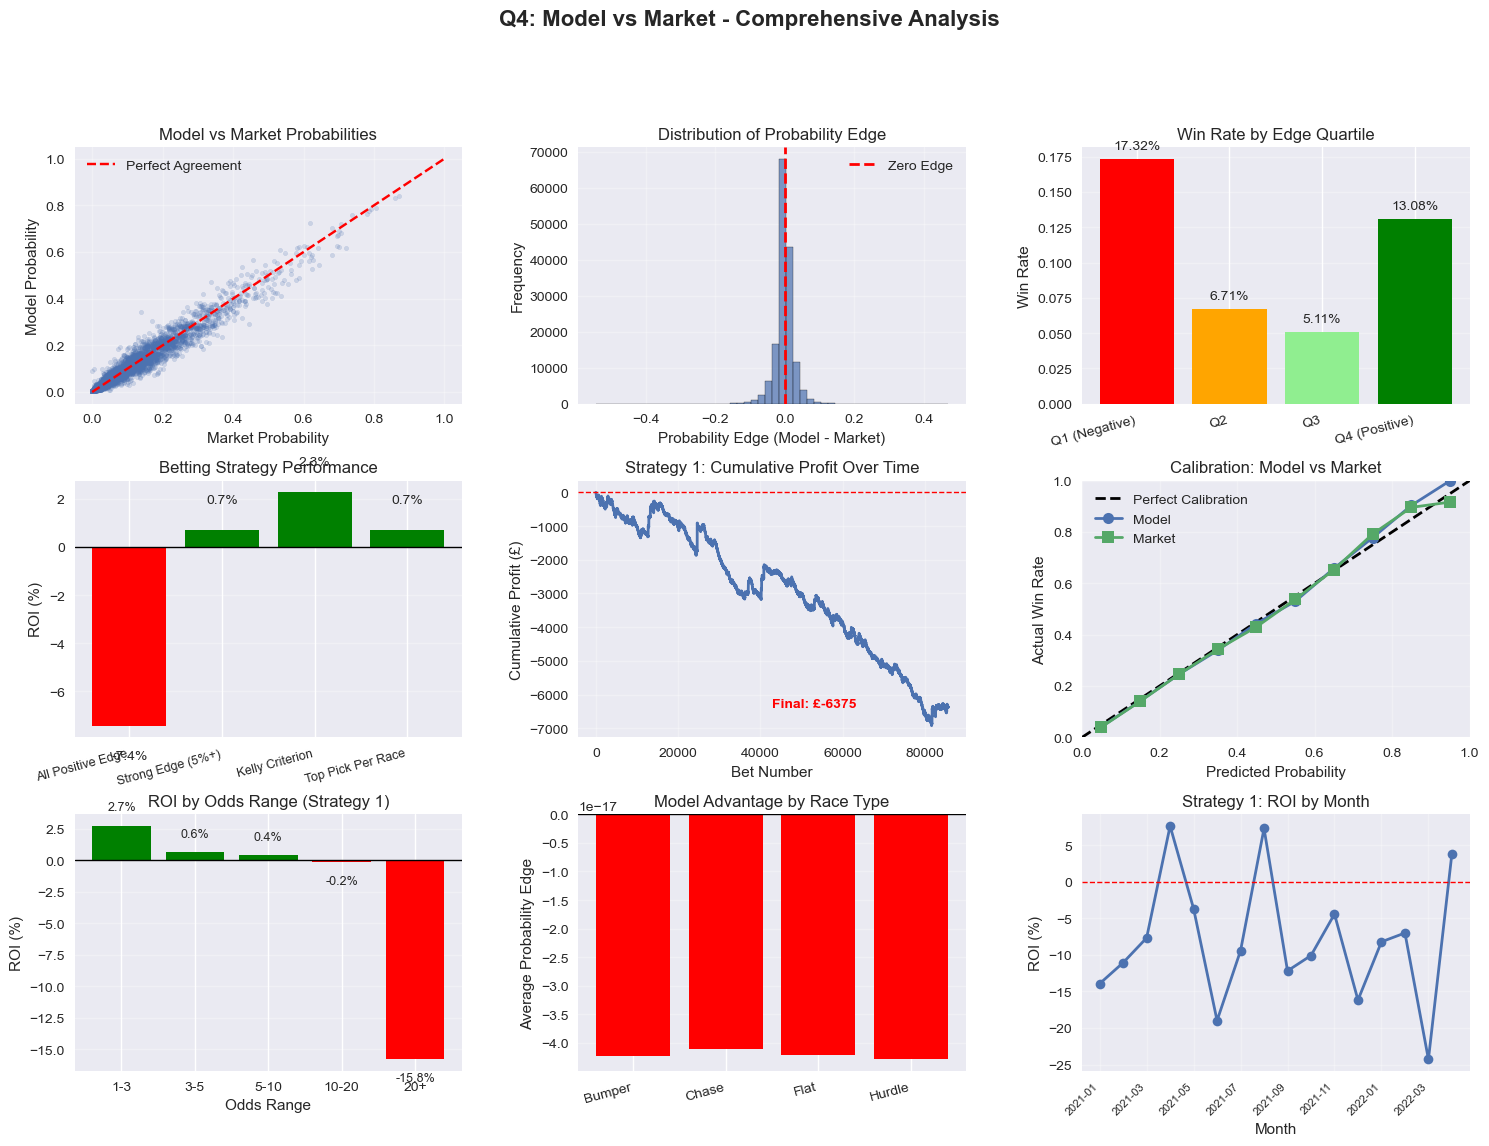

In [11]:
# --------------------------------------------
# Step 6: Visualizations
# --------------------------------------------

print("\n### STEP 6: VISUALIZATIONS ###\n")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Model vs Market Probability Scatter
ax1 = fig.add_subplot(gs[0, 0])
sample = test_df.sample(min(5000, len(test_df)))
ax1.scatter(sample['market_probability_normalized'], sample['model_win_probability_calibrated'], 
            alpha=0.2, s=10)
ax1.plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
ax1.set_xlabel('Market Probability')
ax1.set_ylabel('Model Probability')
ax1.set_title('Model vs Market Probabilities')
ax1.legend()
ax1.grid(True, alpha=0.3)


# 2. Probability Edge Distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(test_df['probability_edge'], bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Edge')
ax2.set_xlabel('Probability Edge (Model - Market)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Probability Edge')
ax2.legend()
ax2.grid(True, alpha=0.3)


# 3. Win Rate by Edge Quartile
ax3 = fig.add_subplot(gs[0, 2])
test_df['edge_quartile'] = pd.qcut(test_df['probability_edge'], q=4, 
                                     labels=['Q1 (Negative)', 'Q2', 'Q3', 'Q4 (Positive)'],
                                     duplicates='drop')
edge_winrate = test_df.groupby('edge_quartile')['obs__is_winner'].mean()
ax3.bar(range(len(edge_winrate)), edge_winrate.values, 
        color=['red', 'orange', 'lightgreen', 'green'])
ax3.set_xticks(range(len(edge_winrate)))
ax3.set_xticklabels(edge_winrate.index, rotation=15, ha='right')
ax3.set_ylabel('Win Rate')
ax3.set_title('Win Rate by Edge Quartile')
for i, v in enumerate(edge_winrate.values):
    ax3.text(i, v + 0.005, f'{v:.2%}', ha='center', va='bottom')
ax3.grid(True, alpha=0.3, axis='y')


# 4. Strategy Performance Comparison
ax4 = fig.add_subplot(gs[1, 0])
strategies = strategy_summary['Strategy']
rois = strategy_summary['ROI (%)']
colors = ['green' if x > 0 else 'red' for x in rois]
ax4.bar(range(len(strategies)), rois, color=colors)
ax4.axhline(0, color='black', linestyle='-', linewidth=1)
ax4.set_xticks(range(len(strategies)))
ax4.set_xticklabels(strategies, rotation=15, ha='right', fontsize=9)
ax4.set_ylabel('ROI (%)')
ax4.set_title('Betting Strategy Performance')
for i, v in enumerate(rois):
    ax4.text(i, v + (1 if v > 0 else -1), f'{v:.1f}%', ha='center', va='bottom' if v > 0 else 'top')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Cumulative Profit (Strategy 1)
ax5 = fig.add_subplot(gs[1, 1])
if len(strategy1_df) > 0:
    strategy1_sorted = strategy1_df.sort_values('date')
    strategy1_sorted['cumulative_profit'] = strategy1_sorted['profit'].cumsum()
    ax5.plot(range(len(strategy1_sorted)), strategy1_sorted['cumulative_profit'], linewidth=2)
    ax5.axhline(0, color='red', linestyle='--', linewidth=1)
    ax5.set_xlabel('Bet Number')
    ax5.set_ylabel('Cumulative Profit (£)')
    ax5.set_title('Strategy 1: Cumulative Profit Over Time')
    ax5.grid(True, alpha=0.3)
    
    final_profit = strategy1_sorted['cumulative_profit'].iloc[-1]
    color = 'green' if final_profit > 0 else 'red'
    ax5.text(len(strategy1_sorted)*0.5, final_profit, f'Final: £{final_profit:.0f}', 
             color=color, fontsize=10, fontweight='bold')

# 6. Calibration: Model vs Market
ax6 = fig.add_subplot(gs[1, 2])

# Bin both model and market predictions
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)

model_bin_actual = []
market_bin_actual = []
bin_centers = []

for i in range(n_bins):
    mask_model = (test_df['model_win_probability_calibrated'] >= bins[i]) & \
                 (test_df['model_win_probability_calibrated'] < bins[i+1])
    mask_market = (test_df['market_probability_normalized'] >= bins[i]) & \
                  (test_df['market_probability_normalized'] < bins[i+1])
    
    if mask_model.sum() > 0:
        model_bin_actual.append(test_df.loc[mask_model, 'obs__is_winner'].mean())
    else:
        model_bin_actual.append(np.nan)
    
    if mask_market.sum() > 0:
        market_bin_actual.append(test_df.loc[mask_market, 'obs__is_winner'].mean())
    else:
        market_bin_actual.append(np.nan)
    
    bin_centers.append((bins[i] + bins[i+1]) / 2)

ax6.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
ax6.plot(bin_centers, model_bin_actual, 'o-', label='Model', linewidth=2, markersize=8)
ax6.plot(bin_centers, market_bin_actual, 's-', label='Market', linewidth=2, markersize=8)
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Actual Win Rate')
ax6.set_title('Calibration: Model vs Market')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_xlim([0, 1])
ax6.set_ylim([0, 1])

# 7. ROI by Odds Range
ax7 = fig.add_subplot(gs[2, 0])
test_df['odds_range'] = pd.cut(test_df['obs__bsp'], bins=[1, 3, 5, 10, 20, 1000],
                                 labels=['1-3', '3-5', '5-10', '10-20', '20+'])

if len(strategy1_df) > 0:
    strategy1_df['odds_range'] = pd.cut(strategy1_df['obs__bsp'], bins=[1, 3, 5, 10, 20, 1000],
                                         labels=['1-3', '3-5', '5-10', '10-20', '20+'])
    
    roi_by_odds = strategy1_df.groupby('odds_range').apply(
        lambda x: (x['profit'].sum() / x['stake'].sum() * 100) if x['stake'].sum() > 0 else 0
    )

    colors = ['green' if x > 0 else 'red' for x in roi_by_odds.values]
    ax7.bar(range(len(roi_by_odds)), roi_by_odds.values, color=colors)
    ax7.axhline(0, color='black', linestyle='-', linewidth=1)
    ax7.set_xticks(range(len(roi_by_odds)))
    ax7.set_xticklabels(roi_by_odds.index)
    ax7.set_xlabel('Odds Range')
    ax7.set_ylabel('ROI (%)')
    ax7.set_title('ROI by Odds Range (Strategy 1)')
    for i, v in enumerate(roi_by_odds.values):
        ax7.text(i, v + (1 if v > 0 else -1), f'{v:.1f}%', ha='center', 
                 va='bottom' if v > 0 else 'top', fontsize=9)
    ax7.grid(True, alpha=0.3, axis='y')

# 8. Model Advantage by Race Type
ax8 = fig.add_subplot(gs[2, 1])

# Check if race_type columns exist
race_type_col = None
for col in ['race_type_simple', 'race_type']:
    if col in test_df.columns:
        race_type_col = col
        break

if race_type_col:
    advantage_by_type = test_df.groupby(race_type_col).apply(
        lambda x: (x['model_win_probability_calibrated'] - x['market_probability_normalized']).mean()
    )

    colors = ['green' if x > 0 else 'red' for x in advantage_by_type.values]
    ax8.bar(range(len(advantage_by_type)), advantage_by_type.values, color=colors)
    ax8.axhline(0, color='black', linestyle='-', linewidth=1)
    ax8.set_xticks(range(len(advantage_by_type)))
    ax8.set_xticklabels(advantage_by_type.index, rotation=15, ha='right')
    ax8.set_ylabel('Average Probability Edge')
    ax8.set_title('Model Advantage by Race Type')
    ax8.grid(True, alpha=0.3, axis='y')
else:
    ax8.text(0.5, 0.5, 'Race type data not available', 
             ha='center', va='center', transform=ax8.transAxes)
    ax8.set_title('Model Advantage by Race Type')

# 9. Value Bet Performance Over Time
ax9 = fig.add_subplot(gs[2, 2])
if len(strategy1_df) > 0:
    strategy1_sorted = strategy1_df.sort_values('date')
    strategy1_sorted['month'] = strategy1_sorted['date'].dt.to_period('M')
    
    monthly_roi = strategy1_sorted.groupby('month').apply(
        lambda x: (x['profit'].sum() / x['stake'].sum() * 100) if x['stake'].sum() > 0 else 0
    )

    ax9.plot(range(len(monthly_roi)), monthly_roi.values, marker='o', linewidth=2)
    ax9.axhline(0, color='red', linestyle='--', linewidth=1)
    ax9.set_xlabel('Month')
    ax9.set_ylabel('ROI (%)')
    ax9.set_title('Strategy 1: ROI by Month')
    ax9.grid(True, alpha=0.3)
    
    # Show only every Nth label to avoid crowding
    n_labels = min(len(monthly_roi), 6)
    step = max(1, len(monthly_roi) // n_labels)
    ax9.set_xticks(range(0, len(monthly_roi), step))
    ax9.set_xticklabels
    ax9.set_xticklabels([str(monthly_roi.index[i]) for i in range(0, len(monthly_roi), step)], 
                        rotation=45, ha='right', fontsize=8)

plt.suptitle('Q4: Model vs Market - Comprehensive Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [12]:
# --------------------------------------------
# Step 7: Detailed Analysis by Subset
# --------------------------------------------

print("\n### STEP 7: PERFORMANCE BY RACE CHARACTERISTICS ###\n")

# Analysis by field size
print("ROI by Field Size (Strategy 1):")
if len(strategy1_df) > 0:
    strategy1_df['field_size_group'] = pd.cut(strategy1_df['n_runners'], 
                                               bins=[0, 8, 12, 16, 100],
                                               labels=['Small (≤8)', 'Medium (9-12)', 
                                                      'Large (13-16)', 'Very Large (17+)'])
    
    field_analysis = strategy1_df.groupby('field_size_group').agg({
        'stake': 'sum',
        'profit': 'sum',
        'obs__is_winner': 'count'
    })
    field_analysis['ROI (%)'] = (field_analysis['profit'] / field_analysis['stake'] * 100)
    field_analysis.columns = ['Total Staked', 'Profit', 'Num Bets', 'ROI (%)']
    
    display(field_analysis)

# Analysis by odds range
print("\n\nROI by Odds Range (Strategy 1):")
if len(strategy1_df) > 0:
    odds_analysis = strategy1_df.groupby('odds_range').agg({
        'stake': 'sum',
        'profit': 'sum',
        'obs__is_winner': ['count', 'sum']
    })

odds_analysis.columns = ['Total Staked', 'Profit', 'Num Bets', 'Wins']
odds_analysis['ROI (%)'] = (odds_analysis['Profit'] / odds_analysis['Total Staked'] * 100)
odds_analysis['Win Rate'] = (odds_analysis['Wins'] / odds_analysis['Num Bets'] * 100)
    
display(odds_analysis)


### STEP 7: PERFORMANCE BY RACE CHARACTERISTICS ###

ROI by Field Size (Strategy 1):


,Total Staked,Profit,Num Bets,ROI (%)
field_size_group,,,,
Small (≤8),24382,-1427.814,24382,-5.856017
Medium (9-12),32557,-2299.132,32557,-7.061867
Large (13-16),21296,-1306.491,21296,-6.134913
Very Large (17+),7467,-1341.142,7467,-17.960921




ROI by Odds Range (Strategy 1):


,Total Staked,Profit,Num Bets,Wins,ROI (%),Win Rate
odds_range,,,,,,
1-3,3093,84.116,3093,1406,2.719560,45.457485
3-5,6688,42.497,6688,1676,0.635422,25.059809
5-10,15571,59.926,15571,2213,0.384856,14.212318
10-20,19322,-33.342,19322,1386,-0.172560,7.173170
20+,40969,-6468.776,40969,728,-15.789441,1.776953


In [13]:
# --------------------------------------------
# Step 8: Summary Statistics
# --------------------------------------------

print("\n### STEP 8: FINAL SUMMARY ###\n")

print("="*60)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*60)

print(f"""
MODEL PERFORMANCE:
  ROC-AUC: {model_auc:.4f}
  Log Loss: {model_logloss:.4f}
  
MARKET COMPARISON:
  Market ROC-AUC: {market_auc:.4f}
  Market Log Loss: {market_logloss:.4f}
  Model vs Market (ROC-AUC): {model_auc - market_auc:+.4f}
  Model vs Market (Log Loss): {model_logloss - market_logloss:+.4f}

BEST BETTING STRATEGY:
""")

best_strategy_idx = strategy_summary['ROI (%)'].idxmax()
best_strategy = strategy_summary.iloc[best_strategy_idx]

print(f"  Strategy: {best_strategy['Strategy']}")
print(f"  Number of Bets: {best_strategy['Bets']:,.0f}")
print(f"  Total Staked: £{best_strategy['Total Staked']:,.2f}")
print(f"  Profit/Loss: £{best_strategy['Profit/Loss']:,.2f}")
print(f"  ROI: {best_strategy['ROI (%)']:.2f}%")

if best_strategy['ROI (%)'] > 0:
    print(f"  ✓ PROFITABLE STRATEGY FOUND")
else:
    print(f"  ✗ No profitable strategy found")

print(f"""
STATISTICAL SIGNIFICANCE:
  Strategy 1 p-value: {p_value:.4f}
  Significance level: {'✓ Significant (p < 0.05)' if p_value < 0.05 else '✗ Not significant (p ≥ 0.05)'}

VALUE BET ANALYSIS:
  Runners with positive edge: {test_df['has_value'].sum():,} ({test_df['has_value'].mean():.1%})
  Value bet win rate: {test_df[test_df['has_value']==1]['obs__is_winner'].mean():.2%}
  Market expected win rate: {test_df[test_df['has_value']==1]['market_probability_normalized'].mean():.2%}
  Outperformance: {(test_df[test_df['has_value']==1]['obs__is_winner'].mean() - test_df[test_df['has_value']==1]['market_probability_normalized'].mean()):.2%}
""")

print("="*60)


### STEP 8: FINAL SUMMARY ###

COMPREHENSIVE RESULTS SUMMARY

MODEL PERFORMANCE:
  ROC-AUC: 0.7909
  Log Loss: 0.2801
  
MARKET COMPARISON:
  Market ROC-AUC: 0.7972
  Market Log Loss: 0.2772
  Model vs Market (ROC-AUC): -0.0064
  Model vs Market (Log Loss): +0.0029

BEST BETTING STRATEGY:

  Strategy: Kelly Criterion
  Number of Bets: 85,702
  Total Staked: £24,989.99
  Profit/Loss: £568.55
  ROI: 2.28%
  ✓ PROFITABLE STRATEGY FOUND

STATISTICAL SIGNIFICANCE:
  Strategy 1 p-value: 0.0011
  Significance level: ✓ Significant (p < 0.05)

VALUE BET ANALYSIS:
  Runners with positive edge: 85,702 (55.1%)
  Value bet win rate: 8.65%
  Market expected win rate: 8.57%
  Outperformance: 0.08%



In [14]:
# --------------------------------------------
# Step 9: Key Insights
# --------------------------------------------

print("\n### STEP 9: KEY INSIGHTS ###\n")

print("""
KEY FINDINGS:

1. MODEL vs MARKET ACCURACY:
""")

if model_auc > market_auc:
    print(f"   ✓ Model ROC-AUC ({model_auc:.4f}) BEATS market ({market_auc:.4f})")
    print(f"     The model has better discriminative ability than market odds")
else:
    print(f"   ✗ Market ROC-AUC ({market_auc:.4f}) beats model ({model_auc:.4f})")
    print(f"     Market odds are more accurate at ranking horses")

if model_logloss < market_logloss:
    print(f"   ✓ Model Log Loss ({model_logloss:.4f}) BEATS market ({market_logloss:.4f})")
    print(f"     Model probabilities are better calibrated")
else:
    print(f"   ✗ Market Log Loss ({market_logloss:.4f}) beats model ({model_logloss:.4f})")
    print(f"     Market probabilities are better calibrated")

print("""
2. PROFITABILITY:
""")

profitable_strategies = strategy_summary[strategy_summary['ROI (%)'] > 0]

if len(profitable_strategies) > 0:
    print(f"   ✓ Found {len(profitable_strategies)} profitable strateg{'y' if len(profitable_strategies)==1 else 'ies'}:")
    for _, strat in profitable_strategies.iterrows():
        print(f"     - {strat['Strategy']}: {strat['ROI (%)']:.2f}% ROI on {strat['Bets']:.0f} bets")
else:
    print(f"   ✗ No profitable strategies found")
    print(f"     All strategies resulted in negative ROI")
    print(f"     Market odds may be too efficient, or model needs improvement")

print("""
3. STATISTICAL SIGNIFICANCE:
""")

if p_value < 0.05 and strategy1_roi > 0:
    print(f"   ✓ Strategy 1 results are statistically significant (p={p_value:.4f})")
    print(f"     Strong evidence that profitability is not due to chance")
elif p_value < 0.05 and strategy1_roi < 0:
    print(f"   ⚠ Strategy 1 losses are statistically significant (p={p_value:.4f})")
    print(f"     Model consistently underperforms market")
else:
    print(f"   ✗ Results not statistically significant (p={p_value:.4f})")
    print(f"     Cannot rule out that results are due to chance")
    print(f"     Would need more data or better model to draw conclusions")

print("""
4. WHERE MODEL ADDS VALUE:
""")

# Identify where model performs best
if len(strategy1_df) > 0:
    best_odds_range = odds_analysis['ROI (%)'].idxmax() if 'odds_analysis' in locals() else None
    best_field_size = field_analysis['ROI (%)'].idxmax() if 'field_analysis' in locals() else None
    
    if best_odds_range and odds_analysis.loc[best_odds_range, 'ROI (%)'] > 0:
        print(f"   • Best performance at odds: {best_odds_range} (ROI: {odds_analysis.loc[best_odds_range, 'ROI (%)']:.2f}%)")
    
    if best_field_size and field_analysis.loc[best_field_size, 'ROI (%)'] > 0:
        print(f"   • Best performance in field size: {best_field_size} (ROI: {field_analysis.loc[best_field_size, 'ROI (%)']:.2f}%)")

print("""
5. PRACTICAL IMPLICATIONS:
""")

if best_strategy['ROI (%)'] > 0:
    annual_races = test_df['race_id'].nunique() * (365 / ((test_df['date'].max() - test_df['date'].min()).days))
    annual_bets = (best_strategy['Bets'] / test_df['race_id'].nunique()) * annual_races
    annual_profit = (best_strategy['Profit/Loss'] / best_strategy['Bets']) * annual_bets
    
    print(f"   • Best strategy: {best_strategy['Strategy']}")
    print(f"   • Estimated annual bets: {annual_bets:,.0f}")
    print(f"   • Projected annual profit: £{annual_profit:,.0f} (assuming £1 stakes)")
    print(f"   • Required: Disciplined execution, proper bankroll management")
    print(f"   • Risk: Past performance doesn't guarantee future results")
else:
    print(f"   • No profitable strategy identified in this backtest")
    print(f"   • Model may need improvement or market may be too efficient")
    print(f"   • Consider: More features, different algorithms, or niche markets")

print("\n" + "="*60)
print("Q4 MARKET COMPARISON COMPLETE")
print("="*60)


### STEP 9: KEY INSIGHTS ###


KEY FINDINGS:

1. MODEL vs MARKET ACCURACY:

   ✗ Market ROC-AUC (0.7972) beats model (0.7909)
     Market odds are more accurate at ranking horses
   ✗ Market Log Loss (0.2772) beats model (0.2801)
     Market probabilities are better calibrated

2. PROFITABILITY:

   ✓ Found 3 profitable strategies:
     - Strong Edge (5%+): 0.69% ROI on 4477 bets
     - Kelly Criterion: 2.28% ROI on 85702 bets
     - Top Pick Per Race: 0.72% ROI on 16411 bets

3. STATISTICAL SIGNIFICANCE:

   ⚠ Strategy 1 losses are statistically significant (p=0.0011)
     Model consistently underperforms market

4. WHERE MODEL ADDS VALUE:

   • Best performance at odds: 1-3 (ROI: 2.72%)

5. PRACTICAL IMPLICATIONS:

   • Best strategy: Kelly Criterion
   • Estimated annual bets: 66,274
   • Projected annual profit: £440 (assuming £1 stakes)
   • Required: Disciplined execution, proper bankroll management
   • Risk: Past performance doesn't guarantee future results

Q4 MARKET COMPARIS